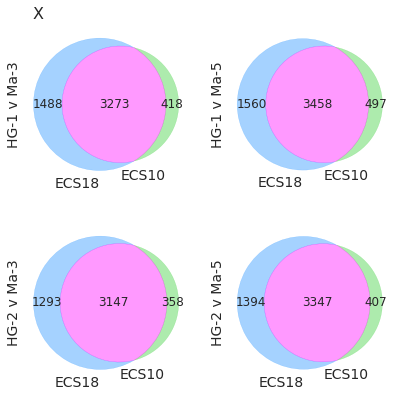

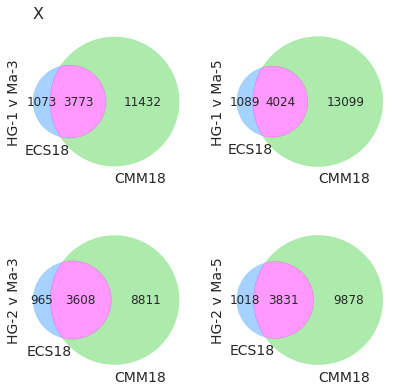

In [111]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib_venn as venn

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot overlaps among unmerged HSP sets as heatmap
# with similarities calculated as Jaccard index

date = '20180723'

run_plot_seg_agreement = True

save_figures = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'penrep', 'ordem', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep', 'isect_raw_other')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
tex_out = os.path.join(base_out, 'supplement', 'supp_table_SX_segcons.tex')
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
                   

def extract_table_header(fpath):
    with open(fpath, 'r') as tab:
        hd = tab.readline().strip('#').strip().split('\t')
        header = ['A_' + h for h in hd]
        header += ['B_' + h for h in hd]
        header.append('overlap')
    return header


def read_overlap_table(fpath, prefix, header=None):
    if header is None:
        header = extract_table_header(fpath)
    df = pd.read_csv(fpath, sep='\t', skiprows=1, header=None,
                     names=header)
    
    # process singletons
    single = df.loc[df['overlap'] == 0, :].copy()
    assert single['A_name'].unique().size == single.shape[0], 'Non-unique singletons'
    single['length'] = single['A_chromEnd'] - single['A_chromStart']
    
    single_cov = single.groupby(['A_sample1', 'A_sample2'], as_index=False)['length'].sum()
    single_cov.columns = ['sample1', 'sample2', prefix + '_uniq_cov']
    
    single_miss = single.groupby(['A_sample1', 'A_sample2'])['A_name'].apply(lambda x: x.unique().size)
    single_miss = single_miss.reset_index(drop=False, inplace=False)
    single_miss.columns = ['sample1', 'sample2', prefix + '_num_missed']
        
    # process shared fragments
    shared = df.loc[df['overlap'] > 0, :].copy()
    select_id_comp = np.logical_and(shared['A_sample1'] == shared['B_sample1'],
                                    shared['A_sample2'] == shared['B_sample2'])
    # reduce to overlaps in same replicate comparisons
    shared = shared.loc[select_id_comp, :].copy()
    
    shared['length'] = shared['A_chromEnd'] - shared['A_chromStart']
    shared_hits = shared.drop_duplicates(['A_name', 'A_sample1', 'A_sample2'], inplace=False)
    shared_hits = shared_hits.groupby(['A_sample1', 'A_sample2'])['A_name'].apply(lambda x: x.unique().size)
    shared_hits = shared_hits.reset_index(drop=False, inplace=False)
    shared_hits.columns = ['sample1', 'sample2', prefix + '_num_hit']
    
    shared_cov = shared.groupby(['A_sample1', 'A_sample2'], as_index=False)['overlap'].sum()
    shared_cov.columns = ['sample1', 'sample2', prefix + '_shared_cov']
    
    stats = single_cov.merge(single_miss).merge(shared_hits).merge(shared_cov)
        
    return stats, header
    


def collect_hsp_agreement(folder, cache_file):
    
    done = set()
    header = None
    for tsv in sorted(os.listdir(folder)):
        if not tsv.endswith('.tsv') or tsv in done:
            continue
        tsv_path = os.path.join(folder, tsv)

        # ecs18-HG_vs_Ma-ordem-ovl-ecs10-HG_vs_Ma-ordem_raw-t1.tsv
        seg1 = tsv.split('-')[0]
        done.add(tsv)
        seg1_stats, header = read_overlap_table(tsv_path, seg1, header)
        
        # inverse direction
        comp1, comp2 = tsv.rsplit('_', 1)[0].split('-ovl-')
        tsv2 = comp2 + '-ovl-' + comp1 + '_raw-t1.tsv'
        seg2 = tsv2.split('-')[0]
        tsv2_path = os.path.join(folder, tsv2)
        done.add(tsv2)
        seg2_stats, header = read_overlap_table(tsv2_path, seg2, header)
    
        cells = tsv2.split('-')[1]
        scoring = tsv2.split('-')[2]
    
        mrg_stats = seg1_stats.merge(seg2_stats, how='outer')
            
        store_path = os.path.join(seg1, seg2, cells, scoring)    
        with pd.HDFStore(cache_file, 'a') as hdf:
            hdf.put(store_path, mrg_stats, format='fixed')

    return cache_file


def plot_overlap_venn(dataset, seg1, seg2, fkey):
    """
    """
            
    ncols = 2
    nrows = 2
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=nrows, ncols=ncols,
                             sharex=False, sharey=False)
        
    ax_idx = itt.product([0, 1], [0, 1])
    for (r, c), row in zip(ax_idx, dataset.itertuples()):
        ax = axes[r, c]
        l1 = row.sample1[7:9] + '-' + row.sample1[3]
        l2 = row.sample2[7:9] + '-' + row.sample2[3]
        label = '{} v {}'.format(l1, l2)
                    
        a_not_b = getattr(row, seg2 + '_num_missed')
        b_not_a = getattr(row, seg1 + '_num_missed')
        a_and_b = getattr(row, seg2 + '_num_hit')
        v = venn.venn2(subsets=(a_not_b, b_not_a, a_and_b),
                       set_labels=(seg2.upper(), seg1.upper()),
                       ax=ax)
        for l in v.subset_labels:
            l.set_fontsize(12)
        for l in v.set_labels:
            l.set_fontsize(14)
        v.get_patch_by_id('10').set_color('dodgerblue')
        v.get_patch_by_id('01').set_color('limegreen')
        v.get_patch_by_id('11').set_color('magenta')
        
        ax.set_axis_on()
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_ylabel(label, fontsize=14, labelpad=0)
        if r == 0 and c == 0:
            tt = ax.set_title(fkey, fontsize=16)
            tt.set_position((0.1, 1.005))
        
    
    return fig, []


def make_tex_table(count_data):
    
    count_data = pd.concat(count_data, axis=0, ignore_index=False)
    for seg in ['ecs10', 'ecs18']:
        count_data[seg + '_total'] = count_data[seg + '_num_missed'] + count_data[seg + '_num_hit']
        count_data[seg + '_hit_rate'] = count_data[seg + '_num_hit'] / count_data[seg + '_total']
    count_data = count_data.groupby(['cell1', 'cell2'])['ecs10_hit_rate', 'ecs18_hit_rate'].mean()
    count_data *= 100
    count_data = count_data.round(1)
    count_data = count_data.reset_index(drop=False, inplace=False)
    count_data.to_latex(tex_out, bold_rows=True, column_format='cccc',
                        encoding='ascii', index=False, header=True)
    return


def plot_segmentation_agreement():
    isect_path = os.path.join(isect_root, 'diff_ident_ident')
    cache_file = os.path.join(cache_dir, '{}_plot_seg-agree_scatter.h5'.format(date))
    if not os.path.isfile(cache_file) or os.stat(cache_file).st_size < 1e5:
        print('Caching')
        _ = collect_hsp_agreement(isect_path, cache_file)
    

    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        res_table = []
        for k in cached_keys:
            if 'ecs10' in k and 'Liver' not in k and 'penem' in k:
                comp = k.split('/')[3]
                c1, c2 = comp.split('_vs_')
                tmp = hdf[k]
                tmp['cell1'] = c1
                tmp['cell2'] = c2
                res_table.append(tmp)
        make_tex_table(res_table)              
                
        for k in cached_keys:
            _, s1, s2, comp, scoring = k.split('/')
            if comp != 'HG_vs_Ma':
                continue
            if scoring != 'penem':
                continue
            if s1 == 'cmm18':
                fk = 'X'
            else:
                fk = 'X'
            data = hdf[k]
        
            fig, exart = plot_overlap_venn(data, s1, s2, fk)

            if save_figures:
                outname = 'fig_{}_raw-agree-venn_{}_{}_{}_{}'.format(fk, s1, s2, scoring, comp)
                outfolder = fig_supp

                out_pdf = os.path.join(outfolder, outname + '.pdf')
                fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)

                out_png = os.path.join(outfolder, outname + '.png')
                fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                    
    return



if run_plot_seg_agreement:
    plot_segmentation_agreement()
